<a href="https://colab.research.google.com/github/Phillistan16/imoco_recon/blob/colab_demo/colab-imoco-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# iterative Motion Compensation (iMoCo) Reconstruction Demo
This CoLab notebook is a demo of the iMoCo method
https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.27998
https://github.com/PulmonaryMRI/imoco_recon


# Setup

<!-- By default, this colab notebook should have a GPU runtime environment. To check this, go to **Runtime > Change runtime type** and see if **GPU** is selected as **Hardware accelerator**. -->

To setup, we will install [SigPy](http://sigpy.readthedocs.io), [ANTs](https://github.com/ANTsX/ANTs) and clone the iMoCo github repo.

To activate GPU environment, go to Runtime -> Change Runtime -> GPU

\#todo

migrate from ANTs to [ANTsPy](https://github.com/ANTsX/ANTsPy)

In [ ]:
# install dependent packages sigpy, h5py, antspy
!pip install sigpy h5py
!pip install antspyx

# clone imoco recon repo
! git clone -b luis_test https://github.com/PulmonaryMRI/imoco_recon

     |████████████████████████████████| 133kB 4.7MB/s 
     |████████████████████████████████| 254.6MB 58kB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
Cloning into 'imoco_recon'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 126 (delta 40), reused 108 (delta 30), pack-reused 0
Receiving objects: 100% (126/126), 59.17 KiB | 1.10 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [8]:
# install ANTs
!git clone https://github.com/ANTsX/ANTs.git
!mkdir build install
%cd build
!cmake /content/ANTs
!make -j 2 2>&1
%cd ANTS-build
!make install 2>&1
import os
os.environ['PATH'] += ":/opt/ANTs/bin"
%cd ../..

Cloning into 'ANTs'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 24558 (delta 37), reused 44 (delta 22), pack-reused 24463
Receiving objects: 100% (24558/24558), 20.51 MiB | 9.02 MiB/s, done.
Resolving deltas: 100% (17484/17484), done.
/content/build
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Not using CCache
-- Setting build type to 'Rel

In [ ]:
# import packages
import imoco_recon.imoco_py.sigpy_e.cfl as cfl
import numpy as np
import sigpy.plot as pl

# Download dataset

Now, let's download a sample Lung UTE dataset. The dataset is hosted on Zenodo: https://zenodo.org/record/3733776#.XoJlNC2ZPOQ.

<!-- The `download_lung_dataset()` function will download the datasets if it cannot find them under `data/lung/`. It takes around 8 minutes to download the datasets. -->

In [2]:
!mkdir lung_mri
!pip install zenodo-get
!zenodo_get -d 10.5281/zenodo.3733775 -o ./lung_mri

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=dc627637c07f875ab7395d198a52172c95eebc13983be5dfb6567442388f0f9e
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Title: Free Breathing Lung MRI Dataset at 3T
Keywords: lung MRI, motion correction
Publication date: 2020-03-30
DOI: 10.5281/zenodo.3733776
Total size: 4800.4 MB

Link: https://zenodo.org/api/files/4e2fa077-5616-489c-b70f-3464b7f2ec44/cfl.py   size: 0.0 MB

Checksum is correct. (54d868ad54b8a2b35606d5771f53c0e0)

Link: https://zenodo.org/api/files/4e2fa077-5616-489c-b70f-3464b7f2ec44/MRI_Raw_datam.cfl   size: 3074.7 MB

Checksum is correct. (ec2e8d5f885147873ce386d99dc90343)

Link: https://zenodo.org/api/files/4e2fa077-5616-489c-b70f-3464b7f2ec44/MRI_Raw_datam.hdr   size: 0.0 MB

Checksum is correct. (f2bf52eb84dd2bc8299c8f058306b765)

Link: https://zenodo.org/api/files/4e2fa077-5616-489c-b70f-3464b7f2ec44/MRI_Raw_d

# Crop Data (Optional)
decrease number of frequency encoding points to adapt for Colab RAM

In [3]:
num_ro = 300

datam = cfl.read_cfl('./lung_mri/MRI_Raw_datam')
datam = datam[:,:,:,:,:num_ro,:]
cfl.write_cfl('./lung_mri/MRI_Raw_datam', datam)

In [4]:
dcf2m = cfl.read_cfl('./lung_mri/MRI_Raw_dcf2m')
dcf2m = dcf2m[:,:,:,:,:num_ro,:]
cfl.write_cfl('./lung_mri/MRI_Raw_dcf2m', dcf2m)

In [5]:
trajm = cfl.read_cfl('./lung_mri/MRI_Raw_trajm')
trajm = trajm[:,:,:,:,:num_ro,:]
cfl.write_cfl('./lung_mri/MRI_Raw_trajm', trajm)

In [6]:
# release RAM
del datam
del dcf2m
del trajm

# iMoCo Reconstruction

## step 1. XD-GRASP, motion-resolved reconstruction 
## step 2. iMoCo reconstruction

When running iMoCo for the first time, use flag --reg_flag 1, which generates the motion field needed for iMoCo reconstruction 

If the motion field exists already (e.g. from previous iMoco recon), no flag is needed

In [5]:
!python imoco_recon/imoco_py/recon_xdgrasp.py ./lung_mri/MRI_Raw --device 0

tcmalloc: large alloc 1478942720 bytes == 0x4f52000 @  0x7f956eb511e7 0x7f956c6775e1 0x7f956c6e090d 0x7f956c6e1522 0x7f956c778bce 0x50a7f5 0x50cfd6 0x509918 0x50a64d 0x50c1f4 0x507f24 0x50b053 0x634dd2 0x634e87 0x63863f 0x6391e1 0x4b0dc0 0x7f956e74eb97 0x5b26fa
Image Shape Estimate: [189, 125, 127]
running calibration
JsenseRecon: 100% 10/10 [00:15<00:00,  1.51s/it]
starting recon
running preconditioner
Time for preconditioner: 10.33378529548645 seconds.
running reconstruction
outer iter:0, res:1.0, time:24.018596649169922 seconds
outer iter:1, res:0.6153977513313293, time:17.450742721557617 seconds
outer iter:2, res:0.41544410586357117, time:17.16857624053955 seconds
outer iter:3, res:0.2900296449661255, time:16.93858504295349 seconds
outer iter:4, res:0.20256295800209045, time:17.415333032608032 seconds
outer iter:5, res:0.13752707839012146, time:16.863698482513428 seconds
outer iter:6, res:0.08738327026367188, time:17.21848487854004 seconds
outer iter:7, res:0.048247795552015305, ti

In [3]:
# imoco recon with motion field derivation
!python imoco_recon/imoco_py/recon_imoco.py ./lung_mri/MRI_Raw --reg_flag 1 --device 0

tcmalloc: large alloc 1478942720 bytes == 0x4fac000 @  0x7f6003bc81e7 0x7f60016ee5e1 0x7f600175790d 0x7f6001758522 0x7f60017efbce 0x50a7f5 0x50cfd6 0x509918 0x50a64d 0x50c1f4 0x507f24 0x50b053 0x634dd2 0x634e87 0x63863f 0x6391e1 0x4b0dc0 0x7f60037c5b97 0x5b26fa
Calibration...
tcmalloc: large alloc 1474011136 bytes == 0x8935a000 @  0x7f6003bc81e7 0x7f60016ee5e1 0x7f6001755420 0x7f600174a7d5 0x7f6001815730 0x7f60017e0317 0x567193 0x511341 0x507f24 0x509c50 0x50a64d 0x50cfd6 0x507f24 0x588e91 0x59fe1e 0x7f600173e4ed 0x50a47f 0x50c1f4 0x507f24 0x509c50 0x50a64d 0x50c1f4 0x507f24 0x50b053 0x634dd2 0x634e87 0x63863f 0x6391e1 0x4b0dc0 0x7f60037c5b97 0x5b26fa
JsenseRecon: 100% 10/10 [00:11<00:00,  1.18s/it]
Registration...
All_Command_lines_OK
Using double precision for computations.
  number of levels = 3
  fixed image: tmp_Im.nii
  moving image: tmp_If.nii
Dimension = 3
Number of stages = 1
Use Histogram Matching true
Winsorize image intensities true
Lower quantile = 0.1
Upper quantile = 1
S

In [1]:
# imoco recon
!python imoco_recon/imoco_py/recon_imoco.py ./lung_mri/MRI_Raw --device 0

tcmalloc: large alloc 1478942720 bytes == 0x4308000 @  0x7f305bc141e7 0x7f305973a5e1 0x7f30597a390d 0x7f30597a4522 0x7f305983bbce 0x50a7f5 0x50cfd6 0x509918 0x50a64d 0x50c1f4 0x507f24 0x50b053 0x634dd2 0x634e87 0x63863f 0x6391e1 0x4b0dc0 0x7f305b811b97 0x5b26fa
Calibration...
tcmalloc: large alloc 1474011136 bytes == 0x886b2000 @  0x7f305bc141e7 0x7f305973a5e1 0x7f30597a1420 0x7f30597967d5 0x7f3059861730 0x7f305982c317 0x567193 0x511341 0x507f24 0x509c50 0x50a64d 0x50cfd6 0x507f24 0x588e91 0x59fe1e 0x7f305978a4ed 0x50a47f 0x50c1f4 0x507f24 0x509c50 0x50a64d 0x50c1f4 0x507f24 0x50b053 0x634dd2 0x634e87 0x63863f 0x6391e1 0x4b0dc0 0x7f305b811b97 0x5b26fa
JsenseRecon: 100% 10/10 [00:11<00:00,  1.19s/it]
Registration...
Motion Field scaling...
Prep...
Preconditioner calculation...
tcmalloc: large alloc 1474011136 bytes == 0x1a4928000 @  0x7f305bc141e7 0x7f305973a5e1 0x7f305979ec78 0x7f305979ef37 0x7f3059836f28 0x50a7f5 0x50cfd6 0x509918 0x50a64d 0x50c1f4 0x509918 0x50a64d 0x50c1f4 0x509918 

# Plot
plot the motion-resolved image and the iMoCo reconstructed image

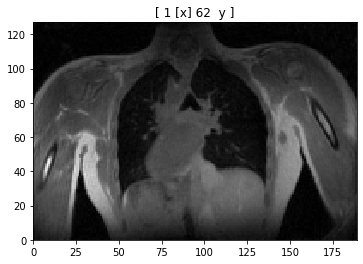

In [2]:
# plot motion-resolved mrL image
mrL = cfl.read_cfl('lung_mri/MRI_Raw_mrL')
pl.ImagePlot(mrL, x = -3, y = -1)

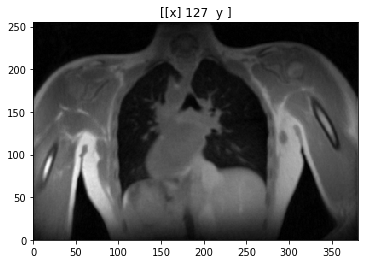

In [3]:
# plot iMoCo image
imoco = cfl.read_cfl('lung_mri/MRI_Raw_imoco')
pl.ImagePlot(imoco, x = -3, y = -1)